In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
# !! unzip data.zip

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [3]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

('reading', 'data/all_codones.pickle')


In [ ]:
######################

In [20]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    
    size = len(index_words_list)
    ran = list(range(size))
    random.shuffle(ran)
    
    for index_words in ran:
        for index, center in enumerate(index_words_list[index_words]):
            context = random.randint(1, context_window_size)
            
            # get a random target before the center word
            for target in index_words_list[index_words][max(0, index - context): index]:
                yield center, target
            
            # get a random target after the center wrod
            for target in index_words_list[index_words][index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]


def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    
    counter = Counter(unique_codones)
    
#     unique_codones = list(set(flat_codones))
    unique_codones = sorted(unique_codones, key=lambda x: counter[x], 
                            reverse=False)            
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary


def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [21]:
dictionary = make_dictionary(all_codones)

print(len(dictionary.keys()))

8454


In [26]:
BATCH_SIZE = 128
SKIP_WINDOW = 10  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [70]:
######################

In [73]:
def fully_conn(input_tensor, from_size, to_size, name):
    def bias_variable(shape, name):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, name=name)

    def weight_variable(shape, name):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name=name)

    with tf.name_scope(name):
        W_fc = weight_variable(shape=[from_size, to_size], name=name + '_W')
        b_fc = bias_variable(shape=[to_size], name=name + '_b')
        h_fc = tf.nn.relu(tf.add(tf.matmul(input_tensor, W_fc), b_fc))
        return h_fc

In [100]:
class SkipGramModel:
    """ Build the graph for word2vec model """
    
    
    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
        self.saver = tf.train.Saver()  # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias

    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')
                 
    
    def _create_embedding(self):
        with tf.name_scope("embed"):
            self.embed_matrix = tf.Variable(tf.random_uniform([self.vocab_size,
                                                               self.embed_size], -1.0, 1.0),
                                            name='embed_matrix')
            
            fc1_ratio = 2
            fc2_ratio = 2
#             fc3_ratio = 2

            self.embed_matrix = fully_conn(self.embed_matrix, self.embed_size, self.embed_size * fc1_ratio, 'fc1')
            self.embed_matrix = fully_conn(self.embed_matrix, self.embed_size * fc1_ratio,self.embed_size , 'fc2')
#             self.embed_matrix = fully_conn(self.embed_matrix, self.embed_size * fc2_ratio, self.embed_size, 'fc3')
#             self.embed_matrix = fully_conn(self.embed_matrix, self.embed_size * fc3_ratio, self.embed_size, 'fc4')

    def _create_loss(self):
        with tf.name_scope("loss"):
            embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')
            
            fc1_ratio = 16
            fc2_ratio = 16
            fc3_ratio = 8
            
            fc1 = fully_conn(embed, self.embed_size, self.embed_size * fc1_ratio, 'fc1')
            fc2 = fully_conn(fc1, self.embed_size * fc1_ratio, self.embed_size * fc2_ratio, 'fc2')
            fc3 = fully_conn(fc2, self.embed_size * fc2_ratio, self.embed_size * fc3_ratio, 'fc3')
            fc4 = fully_conn(fc3, self.embed_size * fc3_ratio, self.embed_size, 'fc4')
            
            # construct variables for NCE loss
            nce_weight = tf.Variable(tf.truncated_normal([self.vocab_size, self.embed_size],
                                                         stddev=1.0 / (self.embed_size ** 0.5)),
                                     name='nce_weight')
            
#             nce_bias = tf.Variable(tf.zeros([self.vocab_size]), name='nce_bias')
            nce_bias = tf.Variable(tf.truncated_normal([self.vocab_size], stddev=1.0 / (self.embed_size ** 0.5)), 
                                   name='nce_bias')
            
            # define loss function to be NCE loss function
            self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weight,
                                                      biases=nce_bias,
                                                      labels=self.target_words,
#                                                       inputs=embed,
                                                      inputs=fc4,
                                                      num_sampled=self.num_sampled,
                                                      num_classes=self.vocab_size), name='loss')

    def _create_optimizer(self):
        self.optimizer = tf.train.GradientDescentOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)
#         self.optimizer = tf.train.AdamOptimizer(self.lr).minimize(self.loss, global_step=self.global_step)

        

    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            tf.summary.histogram("histogram loss", self.loss)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self._create_placeholders()
        self._create_embedding()
        self._create_loss()
        self._create_optimizer()
        self._create_summaries()

In [101]:
VOCAB_SIZE = 8454
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 16  # Number of negative examples to sample.
LEARNING_RATE = .01
NUM_TRAIN_STEPS = 5000
SKIP_STEP = 500

g = tf.Graph()
with g.as_default():
    model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)
    model.build_graph()

INFO:tensorflow:Summary name histogram loss is illegal; using histogram_loss instead.


In [ ]:
######################

In [11]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [24]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    make_dir('checkpoints')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    
    with tf.Session(graph=g, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
#         if that checkpoint exists, restore from checkpoint
        if ckpt and os.path.isfile(ckpt.model_checkpoint_path):
            model.saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0  # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter('improved_graph/lr' + str(learning_rate), sess.graph)
        initial_step = model.global_step.eval()
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = next(batch_gen)
            feed_dict = {model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op],
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            total_loss += loss_batch
            if (index + 1) % skip_step == 0:
                print('Average loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                model.saver.save(sess, 'checkpoints/skip-gram', index)

        final_embed_matrix = sess.run(model.embed_matrix)
        return final_embed_matrix

In [102]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 499:  36.3
Average loss at step 999:  21.4
Average loss at step 1499:  16.4
Average loss at step 1999:  12.8
Average loss at step 2499:  11.0
Average loss at step 2999:  10.0
Average loss at step 3499:   8.0
Average loss at step 3999:   8.1
Average loss at step 4499:   6.8
Average loss at step 4999:   6.5


In [ ]:
######################

In [103]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [104]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,12.933279,2.320783,TWM
1,2.579767,5.261485,HEL
2,-0.003727,10.354598,NDP
3,3.156600,-3.100335,NDS
4,0.048514,2.137669,SPX


In [105]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

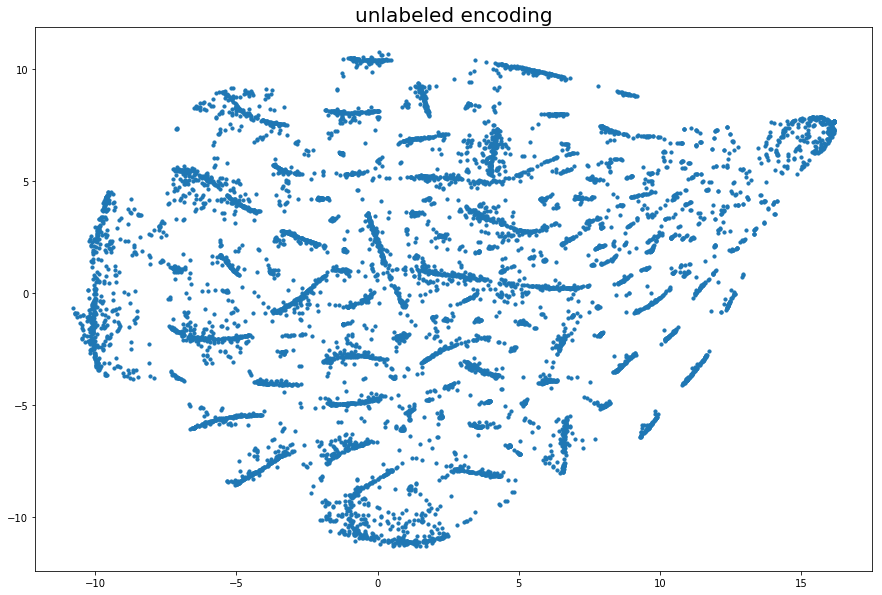

In [106]:
plot_tsne_df(tsne_df)

In [107]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [ ]:
######################

In [95]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [108]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

('reading', 'data/all_acid_dicts.pickle')


In [109]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,TWM,0.100000,139.503300,21.333333,168.933333
1,HEL,-0.966667,126.470300,20.333333,152.766667
2,NDP,-2.866667,108.768400,16.666667,112.633333
3,NDS,-2.600000,105.422433,15.666667,104.733333
4,SPX,-1.200000,92.096250,15.500000,100.850000


In [110]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,TWM,0.100000,139.503300,21.333333,168.933333,12.933279,2.320783
1,HEL,-0.966667,126.470300,20.333333,152.766667,2.579767,5.261485
2,NDP,-2.866667,108.768400,16.666667,112.633333,-0.003727,10.354598
3,NDS,-2.600000,105.422433,15.666667,104.733333,3.156600,-3.100335
4,SPX,-1.200000,92.096250,15.500000,100.850000,0.048514,2.137669


In [98]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

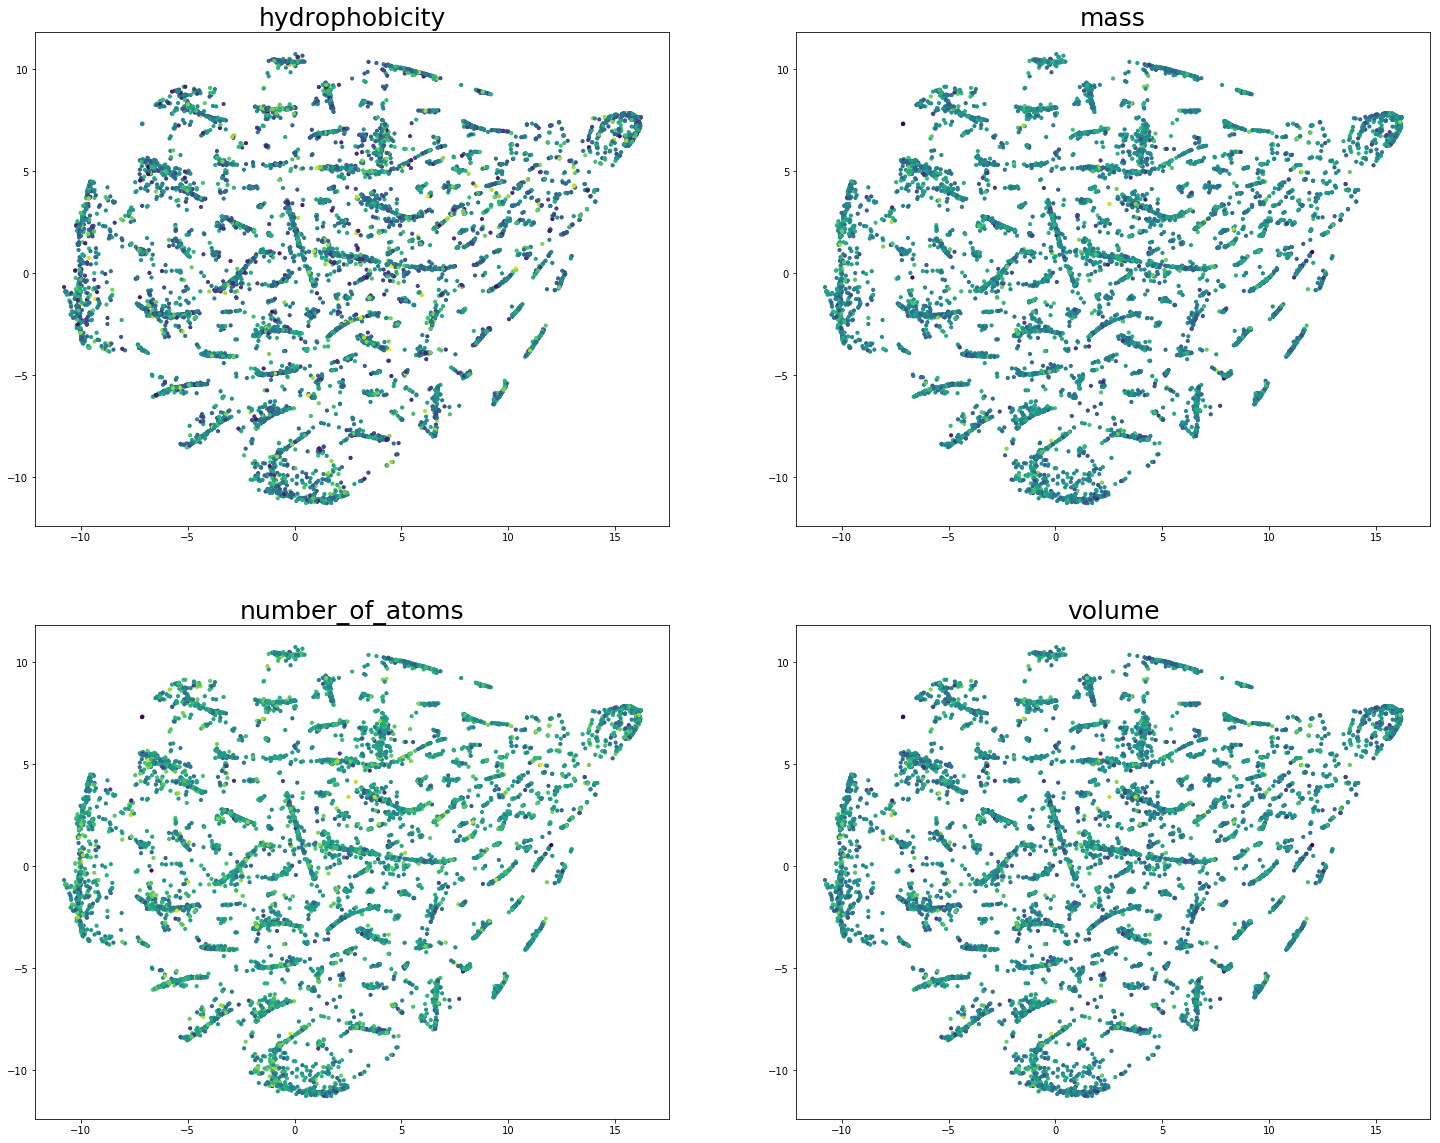

In [111]:
plot_embedding_properties(final_df)

In [ ]:
######################

In [ ]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

In [ ]:
plot_tsne_df(gensim_tsne_df)

In [ ]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

In [ ]:
plot_embedding_properties(final_df_nice)

## Homework

Improve SkipGramModel to archive better embedding for amino acids codones. Visualize your space in the similar style as on the bottom example. You are only allowed to use vanilla tensorflow for this task.

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/